In [13]:
from statistics import mean
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.sectorperformance import SectorPerformances
from alpha_vantage.techindicators import TechIndicators
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import configparser
import pprint
import sys
import os

config = configparser.ConfigParser()

try:
    config.read(os.path.relpath("config.ini"))
except FileExistsError as e:
    print("FileExistsError: {}".format(e))
    sys.exit(1)

pp = pprint.PrettyPrinter()

api                     = tradeapi.REST(
    base_url    = config["alpaca"]["APCA_API_BASE_URL"],
    key_id      = config["alpaca"]["APCA_API_KEY_ID"],
    secret_key  = config["alpaca"]["APCA_API_SECRET_KEY"],
    api_version = config["alpaca"]["VERSION"]
)

account                 = api.get_account()
print("Account #:       {}".format(account.account_number))
print("Currency:        {}".format(account.currency))
print("Cash value:      ${}".format(account.cash))
print("Buying power:    ${}".format(account.buying_power))

print("DT count:        {}".format(account.daytrade_count))
print("DT buying power: ${}".format(account.daytrading_buying_power))

# Check if our account is restricted from trading.
if account.trading_blocked:
    print("Account is currently restricted from trading.")

# Check how much money we can use to open new positions.
print("${} is available as buying power.".format(account.buying_power))

active_assets = api.list_assets(status="active")

# Filter the assets down to just those on NASDAQ.
nasdaq_assets = [a for a in active_assets if a.exchange == "NASDAQ"]
vol_assets = []
for i in list(filter(lambda ass: ass.tradable == True, nasdaq_assets)):
    symbol = i.symbol

    barset = api.get_barset(symbol, "15Min", start="2019-09-01T09:30:00-04:00", end="2019-09-12T09:30:00-04:00")
    symbol_bars = barset[symbol]

    # get trading volume
    volume = [bar.v for bar in symbol_bars if bar is not None]
    if volume is None:
        continue

    else:
        if len(volume) > 0:
            vmean = mean(volume)
            vol_assets.append((symbol, vmean))

    if len(vol_assets) > 3:
        break

    # Submit a market order to buy 1 share of Apple at market price
    # api.submit_order(
    #     symbol="AAPL",
    #     qty=1,
    #     side="buy",
    #     type="market",
    #     time_in_force="gtc"
    # )

    # Submit a limit order to attempt to sell 1 share of AMD at a
    # particular price ($20.50) when the market opens
    # api.submit_order(
    #     symbol="AMD",
    #     qty=1,
    #     side="sell",
    #     type="limit",
    #     time_in_force="opg",
    #     limit_price=20.50
    # )

symbol = sorted(vol_assets, key=lambda ass: ass[1], reverse=True)[0]
print("Symbol: ", symbol)
asset = api.get_asset(symbol[0])
barset = api.get_barset(symbol[0], "15Min", after="2019-09-12T07:00:00-04:00")
symbol_bars = barset[symbol[0]]

alfavantage = TimeSeries(key=config["alpha_vantage"]["API_KEY"], output_format="pandas")
indicators = TechIndicators(key=config["alpha_vantage"]["API_KEY"], output_format="pandas")

Account #:       PA2YJOPZI638
Currency:        USD
Cash value:      $100000
Buying power:    $400000
DT count:        0
DT buying power: $400000
$400000 is available as buying power.
Symbol:  ('TMCX', 420.7)


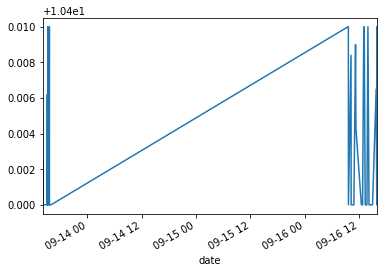

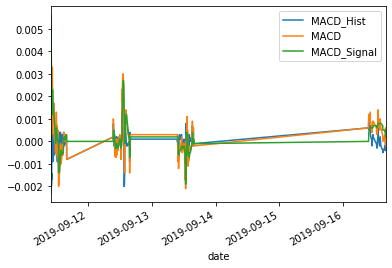

In [17]:
# Get json object with the intraday data and another with  the call's metadata
intraday, i_meta_data = alfavantage.get_intraday(symbol[0], interval="1min")

macd, macd_meta_data = indicators.get_macd(symbol[0], interval="1min")

intraday['4. close'].plot()
macd.plot()

                     MACD_Hist    MACD  MACD_Signal
date                                               
2019-09-16 15:30:00    -0.0008  0.0012       0.0019
2019-09-16 14:30:00    -0.0008  0.0013       0.0021
2019-09-16 13:30:00    -0.0008  0.0015       0.0023
2019-09-16 12:30:00    -0.0008  0.0017       0.0026
2019-09-16 11:30:00    -0.0008  0.0020       0.0028
...                        ...     ...          ...
2019-08-23 14:30:00    -0.0007 -0.0020      -0.0013
2019-08-23 13:30:00    -0.0015 -0.0026      -0.0011
2019-08-23 12:30:00    -0.0014 -0.0022      -0.0008
2019-08-22 15:30:00    -0.0013 -0.0018      -0.0004
2019-08-22 14:30:00    -0.0011 -0.0012      -0.0001

[100 rows x 3 columns]
date
2019-09-16 15:30:00    10.4000
2019-09-16 14:30:00    10.4000
2019-09-16 13:30:00    10.4000
2019-09-16 12:30:00    10.4000
2019-09-16 11:30:00    10.4000
                        ...   
2019-08-23 14:30:00    10.3800
2019-08-23 13:30:00    10.3677
2019-08-23 12:30:00    10.3700
2019-08-22 15:30

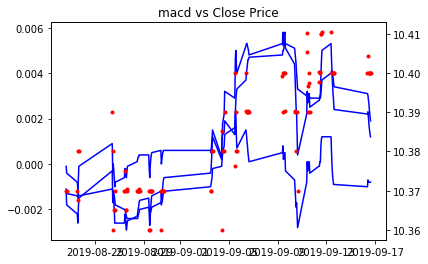

In [16]:
macd.describe()
df1 = macd[:100]
df2 = intraday['4. close']
print(df1)
df1.index = df2.index
print(df2)

fig, ax1 = plt.subplots()
ax1.plot(df1, 'b-')
ax2 = ax1.twinx()
ax2.plot(df2, 'r.')
plt.title('macd vs Close Price')
plt.show()